In [1]:
from google.colab import drive
import os

# 將Google Drive掛載到Colab
drive.mount('/content/drive')

# 設定路徑
patch_previous_path = '/content/drive/My Drive/GAN/patch_Previous'
patches_path = '/content/drive/My Drive/GAN/patches'
patch_next_path = '/content/drive/My Drive/GAN/patch_Next'

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, patches_path, patch_previous_path, patch_next_path, transform=None):
        self.patches_path = patches_path
        self.patch_previous_path = patch_previous_path
        self.patch_next_path = patch_next_path
        self.file_list = os.listdir(patches_path)
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        current_img_path = os.path.join(self.patches_path, self.file_list[idx])
        previous_img_path = os.path.join(self.patch_previous_path, self.file_list[idx])
        next_img_path = os.path.join(self.patch_next_path, self.file_list[idx])

        current_image = Image.open(current_img_path)
        previous_image = Image.open(previous_img_path)
        next_image = Image.open(next_img_path)

        if current_image.size != (64, 64) or previous_image.size != (64, 64) or next_image.size != (64, 64):
            # 跳過尺寸不一致的圖像
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            current_image = self.transform(current_image)
            previous_image = self.transform(previous_image)
            next_image = self.transform(next_image)

        return previous_image, current_image, next_image

# 建立資料集
dataset = CustomDataset(patches_path, patch_previous_path, patch_next_path, transform=ToTensor())


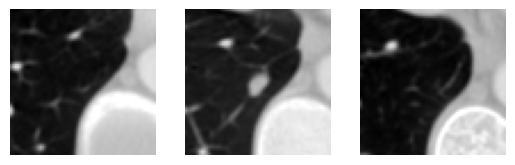

In [11]:
import matplotlib.pyplot as plt

# 獲取索引
index = 4

# 獲取三張圖像
image1, image2, image3 = dataset[index]
previous_image, current_image, next_image = image1, image2, image3

plt.subplot(1, 3, 1)
plt.imshow(previous_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(current_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(next_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim

# 定義生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, previous_image, current_image):
        x = torch.cat([previous_image, current_image], dim=1)
        generated_image = self.model(x)
        return generated_image

# 定義判別器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        validity = self.model(image)
        return validity

In [ ]:
from torch.utils.data import DataLoader

# 超參數設定
batch_size = 32
num_epochs = 5
lr = 0.0002

# 建立資料載入器
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化生成器和判別器
generator = Generator()
discriminator = Discriminator()

# 定義損失函數和優化器
adversarial_loss = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# 將模型移動到設備上
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

Epoch [1/5], Generator Loss: 0.7511, Discriminator Loss: 0.6971


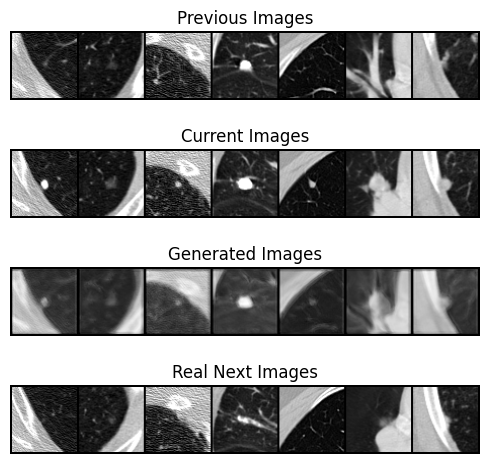

Epoch [2/5], Generator Loss: 0.7420, Discriminator Loss: 0.6757


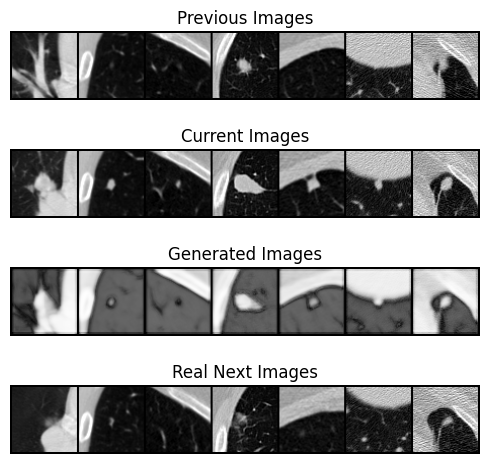

Epoch [3/5], Generator Loss: 0.7154, Discriminator Loss: 0.6897


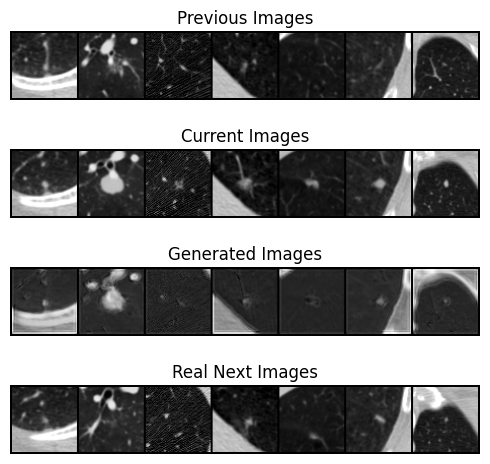

Epoch [4/5], Generator Loss: 0.6844, Discriminator Loss: 0.6945


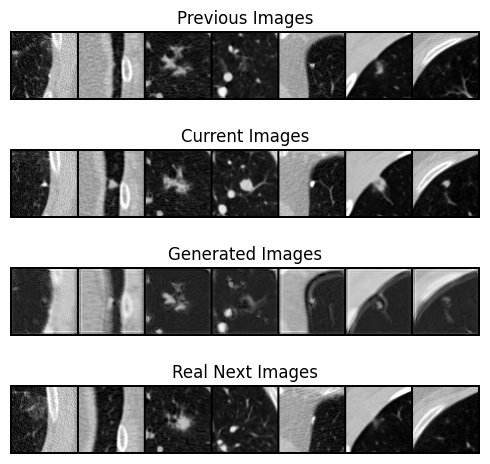

Epoch [5/5], Generator Loss: 0.6843, Discriminator Loss: 0.6987


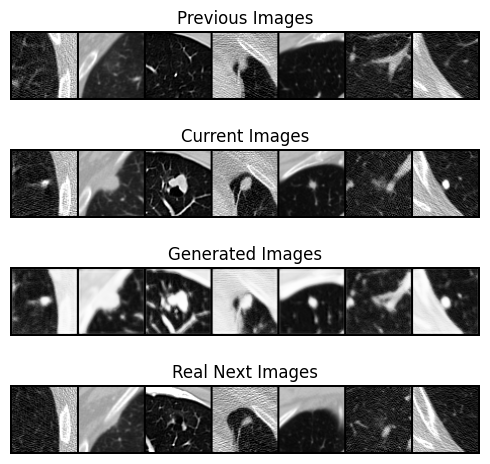

In [ ]:
import torchvision.utils as vutils

# 訓練迴圈
for epoch in range(num_epochs):
    for i, (previous_images, current_images, next_images) in enumerate(data_loader):
        # 將圖像移動到設備上
        previous_images = previous_images.to(device)
        current_images = current_images.to(device)
        next_images = next_images.to(device)

        generator_optimizer.zero_grad()

        # 生成器的輸入噪點
        noise = torch.randn(previous_images.size(0), 1, previous_images.size(2), previous_images.size(3)).to(device)

        # 生成假圖像
        generated_images = generator(previous_images, current_images)

        # 計算生成器的損失
        generator_loss = adversarial_loss(discriminator(generated_images), torch.ones_like(generated_images))

        # 更新生成器的參數
        generator_loss.backward()
        generator_optimizer.step()

        discriminator_optimizer.zero_grad()

        # 計算真實圖像和生成圖像的損失
        real_loss = adversarial_loss(discriminator(next_images), torch.ones_like(next_images))
        fake_loss = adversarial_loss(discriminator(generated_images.detach()), torch.zeros_like(generated_images))
        discriminator_loss = (real_loss + fake_loss) / 2

        # 更新判別器的參數
        discriminator_loss.backward()
        discriminator_optimizer.step()

    # 每個 epoch 結束後顯示損失等資訊
    print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}")

    # 顯示圖像
    generator.eval()
    with torch.no_grad():
        # 選取一些樣本圖像
        sample_previous_images = previous_images[:25].to(device)
        sample_current_images = current_images[:25].to(device)
        sample_next_images = next_images[:25].to(device)
        generated_images = generator(sample_previous_images, sample_current_images).cpu()

    fig, axes = plt.subplots(4, 1, figsize=(5, 5))

    # 顯示先前的圖像
    axes[0].set_title("Previous Images")
    axes[0].imshow(vutils.make_grid(sample_previous_images.cpu(), nrow=7, normalize=True).permute(1, 2, 0))
    axes[0].axis('off')

    # 顯示當前的圖像
    axes[1].set_title("Current Images")
    axes[1].imshow(vutils.make_grid(sample_current_images.cpu(), nrow=7, normalize=True).permute(1, 2, 0))
    axes[1].axis('off')

    # 顯示生成的圖像
    axes[2].set_title("Generated Images")
    axes[2].imshow(vutils.make_grid(generated_images, nrow=7, normalize=True).permute(1, 2, 0))
    axes[2].axis('off')

    # 顯示真實的下一個圖像
    axes[3].set_title("Real Next Images")
    axes[3].imshow(vutils.make_grid(sample_next_images.cpu(), nrow=7, normalize=True).permute(1, 2, 0))
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    generator.train()